In [530]:
import numpy as np
import matplotlib.pyplot as plt
from tpg import TPG, sample_tpg, sample_tpg_2, sample_tpg_h16
from Bernstein import BernsteinPolynomial
import matplotlib.collections as collections
import math
import matplotlib
from collections import defaultdict
import copy
from scipy.optimize import least_squares
from scipy.linalg import lstsq
from scipy.spatial import KDTree
from scipy.spatial import distance
from scipy.optimize import linprog
from collections import defaultdict
import copy
from atpg import uniform_agent_aug_tpg, get_agent
import sympy as sp
import cvxpy

In [531]:
# def find_nn(nodes, qpoint, n):
#     kdtree= KDTree(nodes)

#     # Find the nearest neighbor
#     dist, idx = kdtree.query(qpoint, k = n)
#     nn = nodes[idx]

#     return nn

# def within_barrier(nodes, qpoint, radius):
#     kdtree = KDTree(nodes)

#     # Use query_ball_point to find the indices of nodes within the query point
#     withinrad = kdtree.query_ball_point(qpoint, radius)

#     # Create a boolean array to indicate whether each node is within the query point
#     withinqpoint = np.isin(np.arange(len(nodes)), withinrad)

#     return withinqpoint

# def interpolate_nn(nodes, qpoint, radius):
#     nn = find_nn(nodes, qpoint, 1)

#     # Interpolate from the query point to the nearest neighbor
#     interpolated_points = np.linspace(qpoint, nn, num=100)

#     # Check if any other nodes are within the barrier during interpolation
#     within_barrier = []
#     for point in interpolated_points:
#         within_barrier.append(within_barrier(nodes, point, radius))
    
#     return interpolated_points, np.array(within_barrier)

def gen_edges(nodes, n):
    # Build KDTree from the nodes
    tree = KDTree(nodes)

    # Set to store the visited edges
    visited_edges = set()

    # List to store the connected edges
    edges = []

    # Iterate over each node
    for node in nodes:
        # Find the nearest neighbors
        distances, indices = tree.query(node, k=n+1)  # Including the node itself

        # Convert the indices and distances to a list of tuples
        neighbor_info = list(zip(indices[1:], distances[1:]))

        # Connect the node to its nearest neighbor (excluding itself)
        for neighbor_index, distance in neighbor_info:
            neighbor = tuple(nodes[neighbor_index])  # Convert to tuple

            # Check if the edge has already been visited
            edge = (tuple(node), neighbor)  # Convert node to tuple
            reversed_edge = (neighbor, tuple(node))  # Convert node to tuple
            if edge not in visited_edges and reversed_edge not in visited_edges:
                edges.append(edge)
                visited_edges.add(edge)
                break
        else:
            # If a unique edge is not found, connect to the next nearest neighbor
            for neighbor_index, distance in neighbor_info:
                neighbor = tuple(nodes[neighbor_index])  # Convert to tuple
                edge = (tuple(node), neighbor)  # Create edge with the neighbor
                if edge not in visited_edges and reversed_edge not in visited_edges:
                    edges.append(edge)
                    visited_edges.add(edge)
                    break
            else:
                # If all nearest neighbors are visited, connect to specific nodes
                if np.array_equal(node, [0, 3]):
                    edges.append((tuple(node), (11, 6)))
                    visited_edges.add((tuple(node), (11, 6)))
                elif np.array_equal(node, [4, 12]):
                    edges.append((tuple(node), (12, 18)))
                    visited_edges.add((tuple(node), (12, 18)))
                elif np.array_equal(node, [16, 14]):
                    edges.append((tuple(node), (15, 2)))
                    visited_edges.add((tuple(node), (15, 2)))
                elif np.array_equal(node, [11, 6]):
                    edges.append((tuple(node), (4, 12)))
                    visited_edges.add((tuple(node), (4, 12)))
                elif np.array_equal(node, [15, 2]):
                    edges.append((tuple(node), (16, 14)))
                    visited_edges.add((tuple(node), (16,14)))

    return np.array(edges)

def BernsteinRow(t, N, d=0):
    # Inputs
    # t: a 1D array of time values, between 0 and 1, of length T
    # N: the number of control points

    # Returns
    # A matrix, whose rows contain the Bernstein coefficients (T x N)

    row = []

    if d == 0:
        # Don't take the derivative.
        for i in range(N):
            element = math.comb(N-1, i) * (1-t)**(N-1 - i) * t**i
            row.append(element)
    else:
        t_ = sp.symbols('t')
        for i in range(N):
            # Symbolically represent Bernstein coeff.
            element = math.comb(N-1, i) * (1-t_)**(N-1 - i) * t_**i
            # Take derivative d times
            element = sp.diff(element, t_, d)
            f = sp.lambdify(t_, element)
            row.append(f(t))

    return np.stack(row, axis=-1)

def get_A(t, N, ndim=2, d=0):
    # Inputs
    # t: a 1D array of time values, between 0 and 1, of length T
    # N: number of control points
    # ndim: number of dimensions (i.e. control points are in R^ndim)

    # Returns
    # A matrix for Ordinary Least Squares (Ax = b). Has dimensions (T*ndim x N)

    element = BernsteinRow(t, N, d=d)

    return np.kron(np.eye(ndim,dtype=int),element)

def get_b(points):
    # Input
    # points: list of points to fit B spline to. Must be of shape (T x ndim)

    # Return
    # Flatten vector from points, where the ordering is [x1:T, y1:T, z1:T]
    T, ndim = points.shape

    return (points.T).flatten()

def fit_OLS(t, points, N):
    # Inputs
    # t: sequence of times you want to evaluate the B spline at, corresponding
    # to the point in points with the same index
    # points: list of points to fit to
    # N: number of control points

    # Returns 
    # (1) Ordinary Least Squares solution of control points in the shape (N, ndim)
    # (2) Evaluation of B spline at the time points of t (T, ndim)

    assert len(t) == len(points)        # Make sure your time sequence has the same number of points as points

    T, ndims = points.shape

    A = get_A(t, N, ndim=ndims)
    b = get_b(points)


    x = np.linalg.lstsq(A, b)   # Length (N * ndim)

    X = np.split(x[0], ndims)

    fitted_points = A @ x[0]
    fitted_points = fitted_points.reshape(ndims, T).T

    return np.stack(X, axis=-1), fitted_points

def fit_QP(t, points, N):
    # Inputs
    # t: sequence of times you want to evaluate the B spline at, corresponding
    # to the point in points with the same index
    # points: list of points to fit to
    # N: number of control points

    # Returns 
    # (1) QP solution of control points in the shape (N, ndim)
    # (2) Evaluation of B spline at the time points of t (T, ndim)

    assert len(t) == len(points)        # Make sure your time sequence has the same number of points as points

    T, ndims = points.shape

    A = get_A(t, N, ndim=ndims)
    A_dot = get_A(t, N, ndim=ndims, d=1)

    b = get_b(points)

    # Formulate CVX instance
    x = cvxpy.Variable(A.shape[-1])

    # Predicted points
    predict_pts = A @ x
    predict_pts_ = cvxpy.reshape(predict_pts, (T, ndims))

    # print(predict_pts_.shape)

    # Predicted velocities
    predict_vels = A_dot @ x
    predict_vels_ = cvxpy.reshape(predict_vels, (T, ndims))

    # This is the cost function
    objective = cvxpy.Minimize( cvxpy.sum( (predict_pts - b)**2 ) )

    # This are the constraints. IMPORTANT!!! Change this to reflect your problem formulation.

    # Position constraints
    # Assuming your point are ordered, meaning at points[0] at t=0 and points[-1] at t = 1

    constraints = [
        predict_pts_[0] == points[0],
        predict_pts_[-1] == points[-1]
    ]

    # # Velocity constraints. Set initial and final velocities to 0.
    constraints += [
        predict_vels_[0] == np.zeros(ndims),
        predict_vels_[-1] == np.zeros(ndims)
    ]

    prob = cvxpy.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve(verbose=True)
    # The optimal value for x is stored in `x.value`.
    x = np.array(x.value)

    X = np.split(x, ndims)

    fitted_points = A @ x
    fitted_points = fitted_points.reshape(ndims, T).T

    fitted_vels = A_dot @ x
    fitted_vels = fitted_vels.reshape(ndims, T).T

    return np.stack(X, axis=-1), fitted_points, fitted_vels

def eval_b_spline(t, cntrl_pts):
    N, ndims = cntrl_pts.shape

    # These are fitted positions
    A = get_A(t, N, ndim=ndims)
    cntrl_pt_vec = get_b(cntrl_pts)

    fitted_points = A @ cntrl_pt_vec
    fitted_points = fitted_points.reshape(ndims, len(t)).T

    # These are fitted velocities
    A_dot = get_A(t, N, ndim=ndims, d=1)
    fitted_vels = A @ cntrl_pt_vec
    fitted_vels = fitted_vels.reshape(ndims, len(t)).T

    return fitted_points, fitted_vels


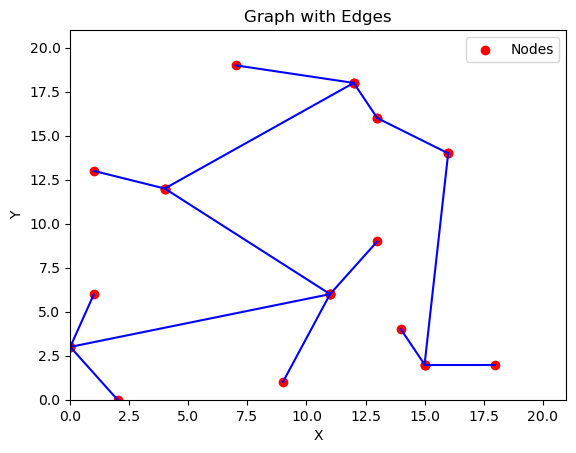

In [532]:
# These are random nodes within Q1 with domain and range of 0 to 20
nodes = np.array([
    [ 9,  1],
    [13,  9],
    [13, 16],
    [ 1,  6],
    [16, 14],
    [12, 18],
    [ 7, 19],
    [18,  2],
    [ 1, 13],
    [ 2,  0],
    [ 0,  3],
    [ 4, 12],
    [14,  4],
    [11,  6],
    [15,  2]
])

edges = gen_edges(nodes, 1)
# print(edges)

# Extract the coordinates from the edges
x_coords = [coord[0] for edge in edges for coord in edge]
y_coords = [coord[1] for edge in edges for coord in edge]

# Create a scatter plot of the nodes
plt.scatter(x_coords, y_coords, color='red', label='Nodes')

# Plot the edges
for edge in edges:
    x = [edge[0][0], edge[1][0]]
    y = [edge[0][1], edge[1][1]]
    plt.plot(x, y, color='blue')

# Set the plot limits and labels
plt.xlim(0, 21)
plt.ylim(0, 21)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph with Edges')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Agent 1 trajectory:
[18, 2]
[15, 2]
[16, 14]
[13, 16]
[12, 18]
[4, 12]
[11, 6]
[9, 1]

Agent 2 trajectory:
[1, 6]
[0, 3]
[11, 6]
[4, 12]
[12, 18]
[13, 16]
[16, 14]
[15, 2]
[14, 4]



/tmp/ipykernel_179812/190011281.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trajectories = np.array([[[18,2], [15,2], [16, 14], [13, 16], [12, 18], [4, 12], [11, 6], [9,1]],


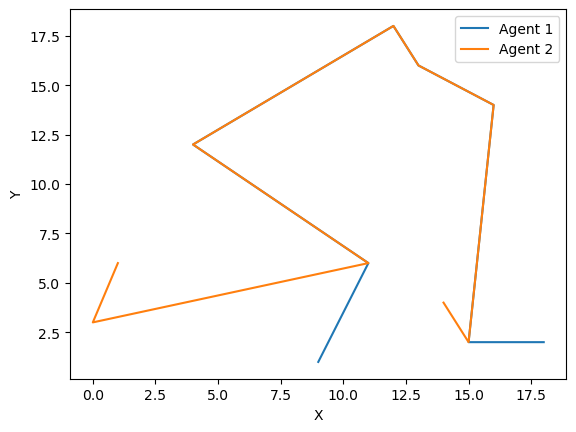

In [533]:
# Set Up Parameters
s_nodes = np.array([[18, 2], [1, 6]])
g_nodes = np.array([[9, 1], [14, 4]])
# print(edges)
trajectories = np.array([[[18,2], [15,2], [16, 14], [13, 16], [12, 18], [4, 12], [11, 6], [9,1]],
                        [[1, 6], [0, 3], [11, 6], [4, 12], [12, 18], [13, 16], [16, 14], [15, 2], [14, 4]]])

# Generate path
# trajectories = find_path(s_nodes, g_nodes, edges)
# print(trajectories)
for i, trajectory in enumerate(trajectories):
    print(f"Agent {i + 1} trajectory:")
    if trajectory is not None:
        for edge in trajectory:
            print(edge)
    else:
        print("No path found for this agent.")
    print()

# Plot the trajectories
for i, trajectory in enumerate(trajectories):
    x = [point[0] for point in trajectory]
    y = [point[1] for point in trajectory]
    plt.plot(x, y, label=f"Agent {i+1}")

# Add labels and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

# Show the plot
plt.show()

In [534]:
# Calculate Distances and Velocity Profile
num_agents = len(trajectories)
max_length = max(len(traj) for traj in trajectories)
distances = np.empty((num_agents, max_length - 1), dtype=float)

for i in range(num_agents):
    num_points = len(trajectories[i])
    for j in range(num_points - 1):
        distance = np.linalg.norm(np.array(trajectories[i][j]) - np.array(trajectories[i][j+1]))
        distances[i, j] = distance

print("Distances:")
print(distances)
print()

sumdist = np.sum(distances, axis=1)
sumdist = sumdist.reshape((-1,1))
print("Total Distance for Each Agent")
print(sumdist)

Distances:
[[  3.          12.04159458   3.60555128   2.23606798  10.
    9.21954446   5.38516481 366.54836601]
 [  3.16227766  11.40175425   9.21954446  10.           2.23606798
    3.60555128  12.04159458   2.23606798]]

Total Distance for Each Agent
[[412.03628911]
 [ 53.90285818]]


In [535]:
# # Calculate for Velocity
# bounds = ((0, 10), (-10, 10))
# start_state = [18, 2]
# end_state = [9, 1]
# T = find_feasible_T(sumdist[1], start_state, end_state, bounds)
# print("The feasible T is:", T)
# x = velocity_profile(sumdist[1], T, start_state, end_state, bounds)

In [536]:
traj1 = np.array(trajectories[0])
traj2 = np.array(trajectories[1])

t1 = np.linspace(0, 1, 100)
t2 = np.linspace(0, 1, 100)
n = 30
ctrlpts1, fitted1, fitted_vels1 = fit_QP(np.linspace(0, 1, len(traj1)), traj1, n)
fitted1, fitted_vels1 = eval_b_spline(t1, ctrlpts1)
ctrlpts2, fitted2, fitted_vels2 = fit_QP(np.linspace(0, 1, len(traj2)), traj2, n)
fitted2, fitted_vels2 = eval_b_spline(t2, ctrlpts2)
print("Control Points for Agent 1:", ctrlpts1)
print("Control Points for Agent 2:", ctrlpts2)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 14 08:23:18 PM: Your problem has 60 variables, 4 constraints, and 0 parameters.
(CVXPY) Jul 14 08:23:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 08:23:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 14 08:23:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 14 08:23:18 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 14 08:23:18 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [537]:
# Create an instance of the Graph class
# g = Graph()
# uncertainty = 1   


# Add edges to the graph from the TPG data
# tpg_data = sample_tpg_2()
# tpg_data = sample_tpg_h16() 

# g.addEdgesFromTPG(tpg_data)

# Perform DFS and check if the TPG contains cycles
# g.DFSAll()

# Generate control points

# print(tpg_data)

# coordinates1 = np.array([[0,2], [7,3],[11,19]])       # sample_tpg_2 agent 1
# coordinates2 = np.array([[17,5],[7,3],[-3,-14],[-3,-14]])   # sample_tpg_2 agent 2

# coordinates1 = np.array([[-1, 3], [5, -7], [2, 3], [10, 4], [-5, -2]])
# coordinates2 = np.array([[5, -7], [2, 3], [4,1], [2, 3], [10, 4]])

# t1 = np.linspace(0, 1, len(coordinates1), endpoint = False)
# t2 = np.linspace(0, 1, len(coordinates2), endpoint = False)
# n = 10
# ctrlpts1, fitted1 = fit_OLS(t1, coordinates1, n)
# ctrlpts2, fitted2 = fit_OLS(t2, coordinates2, n)


Text(0.5, 1.0, 'Velocity Profile for Agent 1')

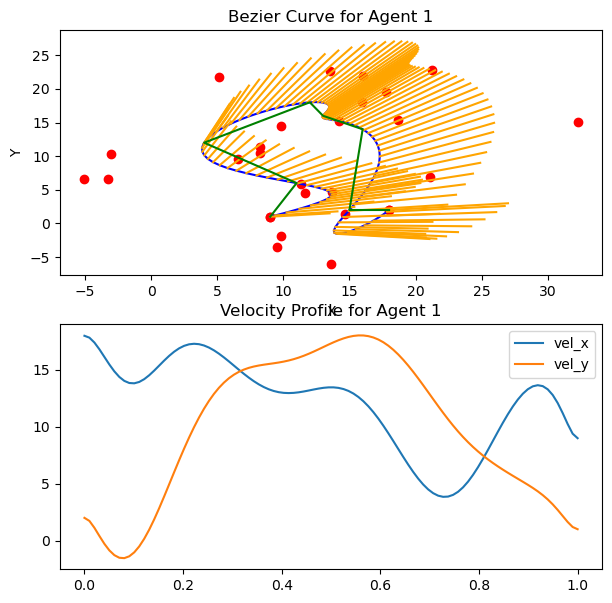

In [538]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))

# Plot fitted points and velocities
ax1.plot(fitted1[:, 0], fitted1[:, 1], color='blue')

for i, vel in enumerate(fitted_vels1):
    pos = fitted1[i]
    pos_plus_vel = pos + vel*0.5
    pts_to_plt = np.stack([pos, pos_plus_vel], axis=0)
    ax1.plot(pts_to_plt[:, 0], pts_to_plt[:, 1], color='orange')

# Plot true points
ax1.plot(traj1[:, 0], traj1[:, 1], color='green')

# Plot control points
ax1.scatter(ctrlpts1[:, 0], ctrlpts1[:, 1], color='red')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Bezier Curve for Agent 1')

# Plot velocity profiles
ax2.plot(np.linspace(0, 1, len(t1)), fitted_vels1[:, 0], label='vel_x')
ax2.plot(np.linspace(0, 1, len(t1)), fitted_vels1[:, 1], label='vel_y')
ax2.legend()
ax2.set_title('Velocity Profile for Agent 1')

Text(0.5, 1.0, 'Velocity Profile for Agent 2')

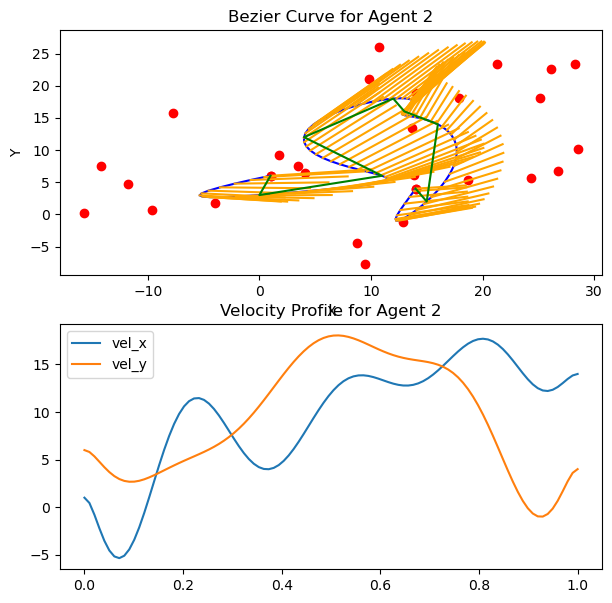

In [539]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))

# Plot fitted points and velocities
ax1.plot(fitted2[:, 0], fitted2[:, 1], color='blue')

for i, vel in enumerate(fitted_vels1):
    pos = fitted2[i]
    pos_plus_vel = pos + vel*0.5
    pts_to_plt = np.stack([pos, pos_plus_vel], axis=0)
    ax1.plot(pts_to_plt[:, 0], pts_to_plt[:, 1], color='orange')

# Plot true points
ax1.plot(traj2[:, 0], traj2[:, 1], color='green')

# Plot control points
ax1.scatter(ctrlpts2[:, 0], ctrlpts2[:, 1], color='red')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Bezier Curve for Agent 2')

# Plot velocity profiles
ax2.plot(np.linspace(0, 1., len(t2)), fitted_vels2[:, 0], label='vel_x')
ax2.plot(np.linspace(0, 1., len(t2)), fitted_vels2[:, 1], label='vel_y')
ax2.legend()
ax2.set_title('Velocity Profile for Agent 2')

In [540]:
t = sp.symbols('t')
pbasis1 = BernsteinRow(t, len(ctrlpts1))
bspline = 0  # Initialize the Bezier curve

for i in range(len(ctrlpts1)):
    bspline += ctrlpts1[i] * pbasis1[i]

# print(bspline)

der = [sp.diff(elem, t) for elem in bspline]
# print(der)

for i in np.linspace(0, 1, 100):
    vel_b = [elem.subs(t, i) for elem in der]
    print(vel_b)

[0, 0]
[-31.0713691310485, -47.7973004135653]
[-52.0542819489025, -68.2373911191654]
[-63.7875992694019, -71.3747562933636]
[-67.2958759797129, -63.8230364356481]
[-63.8188350394048, -49.8859133078040]
[-54.8035334612233, -32.3749914280834]
[-41.8411191257597, -13.1676402314468]
[-26.5644446884542, 6.43463446416892]
[-10.5324933263388, 25.4905041886736]
[4.87506334390504, 43.2981975863891]
[18.5373991438874, 59.3331893831565]
[29.6386896753145, 73.2178850499301]
[37.6804315391376, 84.7059369113217]
[42.4643949166298, 93.6708712050701]
[44.0534775813827, 100.093833904066]
[42.7187128967847, 104.048688146651]
[38.8803224375167, 105.684732741303]
[33.0494761853530, 105.208300361448]
[25.7757524798785, 102.864756499141]
[17.6035089310106, 98.9222314728792]
[9.03872033657571, 93.6579971695700]
[0.526456732411411, 87.3479096713051]
[-7.56186454544227, 80.2588873968185]
[-14.9330008511177, 72.6440454980246]
[-21.3700800605611, 64.7398884599272]
[-26.7264440665438, 56.7648748097358]
[-30.91697

In [541]:
t = sp.symbols('t')
pbasis2 = BernsteinRow(t, len(ctrlpts2))
bspline2 = 0  # Initialize the Bezier curve

for i in range(len(ctrlpts1)):
    bspline2 += ctrlpts2[i] * pbasis2[i]

# print(bspline)

der2 = [sp.diff(elem2, t) for elem2 in bspline2]
# print(der)

for i in np.linspace(0, 1, 100):
    vel_b2 = [elem2.subs(t, i) for elem2 in der2]
    print(vel_b)

[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
